# Setup

In [1]:
# import packages
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
import sys
import matplotlib
from tensorflow import keras
import datetime
import matplotlib.pyplot as plt

In [2]:
# import support libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, \
                                                    img_to_array, load_img
                                                    
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, \
                                        BatchNormalization

from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import ResNet50, InceptionV3, VGG16, Xception

In [3]:
print('Version check:')
print('Python: {}'.format(sys.version))
print('pandas: {}'.format(pd.__version__))
print('NumPy: {}'.format(np.__version__))
print('sklearn: {}'.format(sklearn.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('TensorFlow: {}'.format(tf.__version__))
print('Keras: {}'.format(keras.__version__))

Version check:
Python: 3.8.2 (default, Apr 27 2020, 15:53:34) 
[GCC 9.3.0]
pandas: 1.0.3
NumPy: 1.18.3
sklearn: 0.22.2.post1
matplotlib: 3.2.1
TensorFlow: 2.2.0
Keras: 2.3.0-tf


In [4]:
# Backend Settings

# clear Keras session
keras.backend.clear_session()

# set seeds
np.random.seed(18)
tf.random.set_seed(18)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))
#tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [5]:
tf.config.experimental.list_physical_devices() 

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

# Global functions

In [6]:
class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [7]:
class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [8]:
def train_model(model, optimizer, train_input, val_input, model_name):
    data = dict()

    # Compile model
    model.compile(optimizer = optimizer,
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

    # Create a callback to record training time
    train_rt = TrainRuntimeCallback()

    # Model fitting parameters
    history = model.fit_generator(
        generator = train_input,
        steps_per_epoch = len(sm_train_df) // batch_size,
        epochs = 10,
        callbacks = [train_rt],
        validation_data = val_input,
        validation_steps = (len(sm_val_df) // batch_size)
    )

    train_time = train_rt.process_time
    #print(train_time)

    history_dict = history.history

    data['model'] = model_name
    data['train_time'] = train_time
    data['train_loss'] = history_dict['loss'][-1]
    data['train_acc'] = history_dict['accuracy'][-1]
    data['val_loss'] = history_dict['val_loss'][-1]
    data['val_acc'] = history_dict['val_accuracy'][-1]

    return data, history_dict

In [9]:
def test_model(model, test_input):
    
    data = dict()

    # Create test callback
    test_rt = TestRuntimeCallback()

    test_loss, test_acc = model.evaluate(
        test_input,
        steps = len(sm_test_df) // batch_size,
        callbacks = [test_rt]
    )
    test_time = test_rt.process_time
    data['test_time'] = test_time
    data['test_loss'] = test_loss
    data['test_acc'] = test_acc

    return data

In [10]:
def round_val(val):
    return round(val, 3)

In [11]:
def save_model_data(train_data, test_data):
    data = dict()

    data['model'] = train_data['model']
    data['train_loss'] = round_val(train_data['train_loss'])
    data['train_acc'] = round_val(train_data['train_acc'])
    data['train_time'] = round_val(train_data['train_time'])
    data['val_loss'] = round_val(train_data['val_loss'])
    data['val_acc'] = round_val(train_data['val_acc'])
    data['test_loss'] = round_val(test_data['test_loss'])
    data['test_acc'] = round_val(test_data['test_acc'])
    data['test_time'] = round_val(test_data['test_time'])

    return data

# Load and import data

In [12]:
train_dir = 'data_files/train/'
test_dir = 'data_files/test/'

In [13]:
train_df = pd.read_csv('data_files/train.csv')
test_df = pd.read_csv('data_files/test.csv')

In [14]:
train_df = train_df.sort_values('filename')
test_df = test_df.sort_values('filename')

In [15]:
train_df.head()

,Unnamed: 0,id_code,experiment,plate,well,sirna,filename
0,0,HEPG2-01_1_B03,HEPG2-01,1,B03,513,HEPG2-01_1_B03_s1.jpeg
36515,36515,HEPG2-01_1_B03,HEPG2-01,1,B03,513,HEPG2-01_1_B03_s2.jpeg
1,1,HEPG2-01_1_B04,HEPG2-01,1,B04,840,HEPG2-01_1_B04_s1.jpeg
36516,36516,HEPG2-01_1_B04,HEPG2-01,1,B04,840,HEPG2-01_1_B04_s2.jpeg
2,2,HEPG2-01_1_B05,HEPG2-01,1,B05,1020,HEPG2-01_1_B05_s1.jpeg


In [16]:
test_df.head()

,Unnamed: 0,well_id,experiment,plate,well,filename,sirna_id
0,0,HEPG2-08_1_B03,HEPG2-08,1,B03,HEPG2-08_1_B03_s1.jpeg,855
19897,39794,HEPG2-08_1_B03,HEPG2-08,1,B03,HEPG2-08_1_B03_s2.jpeg,855
1,2,HEPG2-08_1_B04,HEPG2-08,1,B04,HEPG2-08_1_B04_s1.jpeg,710
19898,39796,HEPG2-08_1_B04,HEPG2-08,1,B04,HEPG2-08_1_B04_s2.jpeg,710
2,4,HEPG2-08_1_B05,HEPG2-08,1,B05,HEPG2-08_1_B05_s1.jpeg,836


# Preprocessing

## Subset development train/test set

In [17]:
sirna_subset = list(train_df[train_df.sirna <= 19].sirna.unique())
print(sirna_subset)
print(len(sirna_subset))

[6, 10, 8, 5, 3, 1, 2, 19, 11, 7, 4, 13, 14, 17, 18, 16, 0, 9, 15, 12]
20


In [18]:
len(sirna_subset)

20

In [19]:
type(sirna_subset[0])

numpy.int64

In [20]:
sm_train_df = train_df[train_df.sirna.isin(sirna_subset)].copy()
sm_test_df = test_df[test_df.sirna_id.isin(sirna_subset)].copy()

In [21]:
# Split cell types to only HUVEC

sm_train_df = sm_train_df[sm_train_df.experiment.str.contains('HUVEC')]
sm_test_df = sm_test_df[sm_test_df.experiment.str.contains('HUVEC')]

In [22]:
sm_train_df.head(n=10)

,Unnamed: 0,id_code,experiment,plate,well,sirna,filename
7796,7796,HUVEC-01_1_D11,HUVEC-01,1,D11,1,HUVEC-01_1_D11_s1.jpeg
44311,44311,HUVEC-01_1_D11,HUVEC-01,1,D11,1,HUVEC-01_1_D11_s2.jpeg
7805,7805,HUVEC-01_1_D20,HUVEC-01,1,D20,3,HUVEC-01_1_D20_s1.jpeg
44320,44320,HUVEC-01_1_D20,HUVEC-01,1,D20,3,HUVEC-01_1_D20_s2.jpeg
7836,7836,HUVEC-01_1_F09,HUVEC-01,1,F09,5,HUVEC-01_1_F09_s1.jpeg
44351,44351,HUVEC-01_1_F09,HUVEC-01,1,F09,5,HUVEC-01_1_F09_s2.jpeg
7845,7845,HUVEC-01_1_F21,HUVEC-01,1,F21,10,HUVEC-01_1_F21_s1.jpeg
44360,44360,HUVEC-01_1_F21,HUVEC-01,1,F21,10,HUVEC-01_1_F21_s2.jpeg
7899,7899,HUVEC-01_1_I16,HUVEC-01,1,I16,8,HUVEC-01_1_I16_s1.jpeg
44414,44414,HUVEC-01_1_I16,HUVEC-01,1,I16,8,HUVEC-01_1_I16_s2.jpeg


In [23]:
sm_test_df.head(n=10)

,Unnamed: 0,well_id,experiment,plate,well,filename,sirna_id
4434,8868,HUVEC-17_1_B08,HUVEC-17,1,B08,HUVEC-17_1_B08_s1.jpeg,3
24331,48662,HUVEC-17_1_B08,HUVEC-17,1,B08,HUVEC-17_1_B08_s2.jpeg,3
4536,9072,HUVEC-17_1_G12,HUVEC-17,1,G12,HUVEC-17_1_G12_s1.jpeg,1
24433,48866,HUVEC-17_1_G12,HUVEC-17,1,G12,HUVEC-17_1_G12_s2.jpeg,1
4566,9132,HUVEC-17_1_I04,HUVEC-17,1,I04,HUVEC-17_1_I04_s1.jpeg,6
24463,48926,HUVEC-17_1_I04,HUVEC-17,1,I04,HUVEC-17_1_I04_s2.jpeg,6
4578,9156,HUVEC-17_1_I16,HUVEC-17,1,I16,HUVEC-17_1_I16_s1.jpeg,8
24475,48950,HUVEC-17_1_I16,HUVEC-17,1,I16,HUVEC-17_1_I16_s2.jpeg,8
4581,9162,HUVEC-17_1_I19,HUVEC-17,1,I19,HUVEC-17_1_I19_s1.jpeg,10
24478,48956,HUVEC-17_1_I19,HUVEC-17,1,I19,HUVEC-17_1_I19_s2.jpeg,10


In [24]:
len(sm_train_df)

640

In [25]:
len(sm_test_df)

320

In [26]:
sm_train_df.experiment.unique()

array(['HUVEC-01', 'HUVEC-02', 'HUVEC-03', 'HUVEC-04', 'HUVEC-05',
       'HUVEC-06', 'HUVEC-07', 'HUVEC-08', 'HUVEC-09', 'HUVEC-10',
       'HUVEC-11', 'HUVEC-12', 'HUVEC-13', 'HUVEC-14', 'HUVEC-15',
       'HUVEC-16'], dtype=object)

In [27]:
sm_test_df.experiment.unique()

array(['HUVEC-17', 'HUVEC-18', 'HUVEC-19', 'HUVEC-20', 'HUVEC-21',
       'HUVEC-22', 'HUVEC-23', 'HUVEC-24'], dtype=object)

## Split some data into validation set

In [28]:
val_num = len(sm_train_df) * 0.3 # take 30% of training set

val_df = sm_train_df.sample(int(val_num), random_state = 18)
filename_list = list(val_df.filename)

# Filter dataframes by randomly sampled rows
# Take some from various experiments with same cell line
# also need to shuffle sirna labels
sm_val_df = sm_train_df[sm_train_df.filename.isin(filename_list)]
sm_train_df = sm_train_df[~sm_train_df.filename.isin(filename_list)]
sm_val_df.head()

,Unnamed: 0,id_code,experiment,plate,well,sirna,filename
7796,7796,HUVEC-01_1_D11,HUVEC-01,1,D11,1,HUVEC-01_1_D11_s1.jpeg
44311,44311,HUVEC-01_1_D11,HUVEC-01,1,D11,1,HUVEC-01_1_D11_s2.jpeg
44320,44320,HUVEC-01_1_D20,HUVEC-01,1,D20,3,HUVEC-01_1_D20_s2.jpeg
7845,7845,HUVEC-01_1_F21,HUVEC-01,1,F21,10,HUVEC-01_1_F21_s1.jpeg
7899,7899,HUVEC-01_1_I16,HUVEC-01,1,I16,8,HUVEC-01_1_I16_s1.jpeg


## Data preprocessing

In [29]:
# Settings
batch_size = 32
img_height = 224
img_width = 224
num_outputs = 20

In [30]:
train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [31]:
# train_dir = '/home/specc/Documents/school_files/458_deep_learning/458_final_project/data_files/'
# generator = train_datagen.flow_from_directory(
#     directory=train_dir,
#     target_size=(224, 224),
#     class_mode='categorical',
#     batch_size=32
# )

In [32]:
sm_train_df['sirna'] = sm_train_df.sirna.apply(lambda x: str(x))
sm_test_df['sirna_id'] = sm_test_df.sirna_id.apply(lambda x: str(x))
sm_val_df['sirna'] = sm_val_df.sirna.apply(lambda x: str(x))

In [33]:
train_dir = '/home/specc/Documents/school_files/458_deep_learning/458_final_project/data_files/train/'

train_generator  = train_datagen.flow_from_dataframe(
    dataframe = sm_train_df,
    directory = train_dir,
    target_size = (img_height, img_width),
    subset='training',
    x_col='filename',
    y_col='sirna',
    class_mode='categorical',
    color_mode='rgb',
    shuffle = True,
    batch_size = batch_size
)

Found 448 validated image filenames belonging to 20 classes.


In [34]:
val_generator = train_datagen.flow_from_dataframe(
    dataframe = sm_val_df,
    directory = train_dir,
    target_size = (img_height, img_width),
    #subset = 'validation',
    x_col = 'filename',
    y_col = 'sirna',
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = False,
    batch_size = batch_size
)

Found 192 validated image filenames belonging to 20 classes.


In [35]:
test_dir = 'data_files/test'

test_generator = test_datagen.flow_from_dataframe(
    dataframe = sm_test_df,
    directory = test_dir,
    target_size = (img_height, img_width),
    x_col = 'filename',
    y_col = 'sirna_id',
    color_mode = 'rgb',
    #class_mode = None
)

Found 320 validated image filenames belonging to 20 classes.


In [36]:
sample_training_images, _ = next(train_generator)

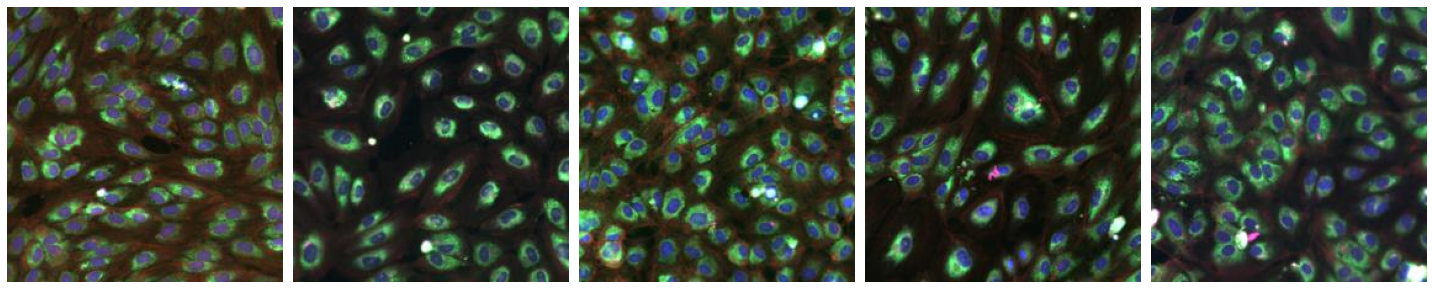

In [37]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:9])

# Base models

In [38]:
# Declare empty list to begin storing data
# data is stored as list of dictionaries
results = list() 

## DNN with 1 hidden layer

In [41]:
model = Sequential()

model.add(Flatten())
model.add(Dense(64, activation='relu', input_shape = (224, 224, 3) ))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(20, activation='softmax'))

model_name = 'DNN (1 layer)'

#model.summary()

# model.compile(
#     optimizer='rmsprop',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

#model.summary()

In [42]:
opt = 'rmsprop'

train_data, history_dict = train_model(model, opt, train_generator, val_generator, model_name)
test_data = test_model(model, test_generator)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
14/14 [==============================] - 1s 97ms/step - loss: 43.6284 - accuracy: 0.0513 - val_loss: 14.0562 - val_accuracy: 0.0469
Epoch 2/10
14/14 [==============================] - 1s 83ms/step - loss: 9.3272 - accuracy: 0.0580 - val_loss: 5.5929 - val_accuracy: 0.0521
Epoch 3/10
14/14 [==============================] - 1s 81ms/step - loss: 3.5799 - accuracy: 0.0379 - val_loss: 2.9960 - val_accuracy: 0.0469
Epoch 4/10
14/14 [==============================] - 1s 79ms/step - loss: 2.9956 - accuracy: 0.0513 - val_loss: 2.9966 - val_accuracy: 0.0469
Epoch 5/10
14/14 [==============================] - 1s 80ms/step - loss: 2.9949 - accuracy: 0.0536 - val_loss: 2.9971 - val_accuracy: 0.0469
Epoch 6/10
14/14 [==============================] - 1s 79ms/step - loss: 2.9948 - accuracy: 0.0491 - val_loss: 2.9977 - val_accuracy: 0.0469
Epoch 7/10
14/14 [==============================] - 1s 84ms/step - loss: 3.1

In [43]:
train_data

{'model': 'DNN (1 layer)',
 'train_time': 12.517458,
 'train_loss': 2.994800090789795,
 'train_acc': 0.0491071417927742,
 'val_loss': 3.0001323223114014,
 'val_acc': 0.046875}

In [44]:
test_data

{'test_time': 0.272941,
 'test_loss': 2.995964527130127,
 'test_acc': 0.05000000074505806}

In [45]:
results.append(save_model_data(train_data, test_data))

In [46]:
results

[{'model': 'DNN (1 layer)',
  'train_loss': 2.995,
  'train_acc': 0.049,
  'train_time': 12.517,
  'val_loss': 3.0,
  'val_acc': 0.047,
  'test_loss': 2.996,
  'test_acc': 0.05,
  'test_time': 0.273}]

## 1 Layer CNN

In [47]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(224, 224 ,3)),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(20, activation='softmax')
])

model_name = 'CNN (1 layer)'


# model.compile(
#     optimizer='rmsprop',
#     loss=tf.keras.losses.categorical_crossentropy,
#     metrics=['accuracy']
# )

In [48]:
opt = 'rmsprop'

train_data, history_dict = train_model(model, opt, train_generator, val_generator, model_name)
test_data = test_model(model, test_generator)
results.append(save_model_data(train_data, test_data))

Epoch 1/10
14/14 [==============================] - 10s 695ms/step - loss: 32.8892 - accuracy: 0.0379 - val_loss: 10.1378 - val_accuracy: 0.0260
Epoch 2/10
14/14 [==============================] - 10s 712ms/step - loss: 5.5044 - accuracy: 0.1339 - val_loss: 3.6824 - val_accuracy: 0.0781
Epoch 3/10
14/14 [==============================] - 10s 703ms/step - loss: 1.9581 - accuracy: 0.4933 - val_loss: 3.0226 - val_accuracy: 0.0833
Epoch 4/10
14/14 [==============================] - 10s 708ms/step - loss: 0.6841 - accuracy: 0.8393 - val_loss: 2.9290 - val_accuracy: 0.1250
Epoch 5/10
14/14 [==============================] - 10s 702ms/step - loss: 0.1090 - accuracy: 0.9866 - val_loss: 3.4388 - val_accuracy: 0.1198
Epoch 6/10
14/14 [==============================] - 10s 709ms/step - loss: 0.0857 - accuracy: 0.9844 - val_loss: 3.0127 - val_accuracy: 0.1198
Epoch 7/10
14/14 [==============================] - 10s 696ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 3.1037 - val_accuracy: 0.11

In [49]:
results

[{'model': 'DNN (1 layer)',
  'train_loss': 2.995,
  'train_acc': 0.049,
  'train_time': 12.517,
  'val_loss': 3.0,
  'val_acc': 0.047,
  'test_loss': 2.996,
  'test_acc': 0.05,
  'test_time': 0.273},
 {'model': 'CNN (1 layer)',
  'train_loss': 0.0,
  'train_acc': 1.0,
  'train_time': 106.381,
  'val_loss': 3.308,
  'val_acc': 0.125,
  'test_loss': 3.452,
  'test_acc': 0.119,
  'test_time': 0.941}]

# Further Experiments

# 1 layer CNN with DO

In [50]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(224, 224 ,3)),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(20, activation='softmax')
])

model_name = 'CNN (1 layer) w 0.2 DO'

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               102760960 
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                10260     
Total params: 102,771,668
Trainable params: 102,771,668
Non-trainable params: 0
________________________________________

In [51]:
opt = 'rmsprop'
train_data, history_dict = train_model(model, opt, train_generator, val_generator, model_name)
test_data = test_model(model, test_generator)
results.append(save_model_data(train_data, test_data))

Epoch 1/10
14/14 [==============================] - 10s 692ms/step - loss: 39.4860 - accuracy: 0.0491 - val_loss: 6.5568 - val_accuracy: 0.0625
Epoch 2/10
14/14 [==============================] - 10s 715ms/step - loss: 5.7455 - accuracy: 0.1562 - val_loss: 4.5122 - val_accuracy: 0.0521
Epoch 3/10
14/14 [==============================] - 10s 708ms/step - loss: 2.2641 - accuracy: 0.4241 - val_loss: 3.1771 - val_accuracy: 0.1302
Epoch 4/10
14/14 [==============================] - 10s 694ms/step - loss: 1.0730 - accuracy: 0.7299 - val_loss: 2.9108 - val_accuracy: 0.1198
Epoch 5/10
14/14 [==============================] - 10s 704ms/step - loss: 0.3786 - accuracy: 0.9286 - val_loss: 2.7897 - val_accuracy: 0.1823
Epoch 6/10
14/14 [==============================] - 10s 686ms/step - loss: 0.1447 - accuracy: 0.9777 - val_loss: 2.8717 - val_accuracy: 0.1510
Epoch 7/10
14/14 [==============================] - 10s 690ms/step - loss: 0.0307 - accuracy: 1.0000 - val_loss: 2.9388 - val_accuracy: 0.140

In [52]:
results

[{'model': 'DNN (1 layer)',
  'train_loss': 2.995,
  'train_acc': 0.049,
  'train_time': 12.517,
  'val_loss': 3.0,
  'val_acc': 0.047,
  'test_loss': 2.996,
  'test_acc': 0.05,
  'test_time': 0.273},
 {'model': 'CNN (1 layer)',
  'train_loss': 0.0,
  'train_acc': 1.0,
  'train_time': 106.381,
  'val_loss': 3.308,
  'val_acc': 0.125,
  'test_loss': 3.452,
  'test_acc': 0.119,
  'test_time': 0.941},
 {'model': 'CNN (1 layer) w 0.2 DO',
  'train_loss': 0.005,
  'train_acc': 1.0,
  'train_time': 105.904,
  'val_loss': 2.877,
  'val_acc': 0.182,
  'test_loss': 3.116,
  'test_acc': 0.094,
  'test_time': 0.969}]

# 2 layer CNN

In [53]:
model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(224, 224 ,3)),
    MaxPooling2D(),

    Conv2D(128, 3, activation='relu', input_shape=(224, 224 ,3)),
    MaxPooling2D(),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(20, activation='softmax')
])

model_name = 'CNN (2 layers)'

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 128)     36992     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 373248)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               191103488 
_________________________________________________________________
dense_8 (Dense)              (None, 20)               

In [54]:
opt = 'rmsprop'
train_data, history_dict = train_model(model, opt, train_generator, val_generator, model_name)
test_data = test_model(model, test_generator)
results.append(save_model_data(train_data, test_data))

Epoch 1/10
14/14 [==============================] - 25s 2s/step - loss: 19.1158 - accuracy: 0.0513 - val_loss: 3.0810 - val_accuracy: 0.0469
Epoch 2/10
14/14 [==============================] - 24s 2s/step - loss: 2.8920 - accuracy: 0.1384 - val_loss: 4.1496 - val_accuracy: 0.0521
Epoch 3/10
14/14 [==============================] - 25s 2s/step - loss: 2.3870 - accuracy: 0.4040 - val_loss: 3.0469 - val_accuracy: 0.0990
Epoch 4/10
14/14 [==============================] - 25s 2s/step - loss: 0.8152 - accuracy: 0.8214 - val_loss: 3.0105 - val_accuracy: 0.1198
Epoch 5/10
14/14 [==============================] - 25s 2s/step - loss: 0.2091 - accuracy: 0.9576 - val_loss: 2.9232 - val_accuracy: 0.1250
Epoch 6/10
14/14 [==============================] - 25s 2s/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 3.1969 - val_accuracy: 0.1198
Epoch 7/10
14/14 [==============================] - 25s 2s/step - loss: 6.9929e-04 - accuracy: 1.0000 - val_loss: 3.2388 - val_accuracy: 0.1250
Epoch 8/10
14/1

In [55]:
results

[{'model': 'DNN (1 layer)',
  'train_loss': 2.995,
  'train_acc': 0.049,
  'train_time': 12.517,
  'val_loss': 3.0,
  'val_acc': 0.047,
  'test_loss': 2.996,
  'test_acc': 0.05,
  'test_time': 0.273},
 {'model': 'CNN (1 layer)',
  'train_loss': 0.0,
  'train_acc': 1.0,
  'train_time': 106.381,
  'val_loss': 3.308,
  'val_acc': 0.125,
  'test_loss': 3.452,
  'test_acc': 0.119,
  'test_time': 0.941},
 {'model': 'CNN (1 layer) w 0.2 DO',
  'train_loss': 0.005,
  'train_acc': 1.0,
  'train_time': 105.904,
  'val_loss': 2.877,
  'val_acc': 0.182,
  'test_loss': 3.116,
  'test_acc': 0.094,
  'test_time': 0.969},
 {'model': 'CNN (2 layers)',
  'train_loss': 0.0,
  'train_acc': 1.0,
  'train_time': 267.183,
  'val_loss': 3.684,
  'val_acc': 0.12,
  'test_loss': 3.853,
  'test_acc': 0.103,
  'test_time': 2.605}]

In [56]:
# Few more experiments then start adjusting datagen

# ResNet50 - baseline

In [57]:
from tensorflow.keras.applications import ResNet50

res_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

res_model.trainable = False

flat1 = Flatten()
class1 = Dense(512, activation='relu')
output = Dense(20, activation = 'softmax')

model = Sequential([
    res_model,
    flat1,
    class1,
    output
])

model_name = 'ResNet50 baseline'

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dense_10 (Dense)             (None, 20)                10260     
Total params: 74,978,708
Trainable params: 51,390,996
Non-trainable params: 23,587,712
_________________________________________________________________


In [58]:
opt = 'rmsprop'
train_data, history_dict = train_model(model, opt, train_generator, val_generator, model_name)

Epoch 1/10
14/14 [==============================] - 26s 2s/step - loss: 54.5805 - accuracy: 0.0513 - val_loss: 21.0327 - val_accuracy: 0.0521
Epoch 2/10
14/14 [==============================] - 25s 2s/step - loss: 13.3174 - accuracy: 0.0469 - val_loss: 10.6753 - val_accuracy: 0.0260
Epoch 3/10
14/14 [==============================] - 25s 2s/step - loss: 6.3118 - accuracy: 0.0491 - val_loss: 5.2573 - val_accuracy: 0.0469
Epoch 4/10
14/14 [==============================] - 27s 2s/step - loss: 3.7461 - accuracy: 0.0469 - val_loss: 3.2647 - val_accuracy: 0.0417
Epoch 5/10
14/14 [==============================] - 29s 2s/step - loss: 3.0318 - accuracy: 0.0670 - val_loss: 2.9971 - val_accuracy: 0.0469
Epoch 6/10
14/14 [==============================] - 29s 2s/step - loss: 2.9934 - accuracy: 0.0759 - val_loss: 2.9994 - val_accuracy: 0.0625
Epoch 7/10
14/14 [==============================] - 29s 2s/step - loss: 3.0037 - accuracy: 0.0513 - val_loss: 2.9965 - val_accuracy: 0.0469
Epoch 8/10
14/14

In [59]:
test_data = test_model(model, test_generator)
results.append(save_model_data(train_data, test_data))

10/10 [==============================] - 12s 1s/step - loss: 2.9962 - accuracy: 0.0469


# ResNet50 - Unfreeze last 100 layers

In [60]:
res_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

flat = Flatten()(res_model.output)
output = Dense(20, activation='softmax')(flat)

model = Model(res_model.input, output)

model_name = 'ResNet50 (unfreeze last 100 layers)'

for layer in res_model.layers[:-99]:
    layer.trainable = False

model.summary()

[0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 14, 14, 256)  0           conv4_block1_2_bn[0][0]      

In [61]:
opt = 'rmsprop'
train_data, history_dict = train_model(model, opt, train_generator, val_generator, model_name)

Epoch 1/10
14/14 [==============================] - 50s 4s/step - loss: 23.1219 - accuracy: 0.0469 - val_loss: 505.2698 - val_accuracy: 0.0729
Epoch 2/10
14/14 [==============================] - 49s 4s/step - loss: 5.5293 - accuracy: 0.0536 - val_loss: 43.0285 - val_accuracy: 0.0469
Epoch 3/10
14/14 [==============================] - 51s 4s/step - loss: 3.3920 - accuracy: 0.0424 - val_loss: 50.8644 - val_accuracy: 0.0260
Epoch 4/10
14/14 [==============================] - 51s 4s/step - loss: 3.0453 - accuracy: 0.0446 - val_loss: 39.6053 - val_accuracy: 0.0260
Epoch 5/10
14/14 [==============================] - 51s 4s/step - loss: 3.3385 - accuracy: 0.0491 - val_loss: 159.7453 - val_accuracy: 0.0625
Epoch 6/10
14/14 [==============================] - 50s 4s/step - loss: 5.1628 - accuracy: 0.0536 - val_loss: 109.7707 - val_accuracy: 0.0729
Epoch 7/10
14/14 [==============================] - 51s 4s/step - loss: 4.2262 - accuracy: 0.0826 - val_loss: 481.8665 - val_accuracy: 0.0365
Epoch 8/

In [62]:
test_data = test_model(model, test_generator)
results.append(save_model_data(train_data, test_data))

10/10 [==============================] - 11s 1s/step - loss: 238.4955 - accuracy: 0.0281


In [63]:
pd.DataFrame(results)

,model,train_loss,train_acc,train_time,val_loss,val_acc,test_loss,test_acc,test_time
0,DNN (1 layer),2.995,0.049,12.517,3.000,0.047,2.996,0.050,0.273
1,CNN (1 layer),0.000,1.000,106.381,3.308,0.125,3.452,0.119,0.941
2,CNN (1 layer) w 0.2 DO,0.005,1.000,105.904,2.877,0.182,3.116,0.094,0.969
3,CNN (2 layers),0.000,1.000,267.183,3.684,0.120,3.853,0.103,2.605
4,ResNet50 baseline,2.995,0.036,289.801,2.998,0.047,2.996,0.047,13.389
5,ResNet50 (unfreeze last 100 layers),2.751,0.145,544.320,242.017,0.073,238.496,0.028,12.489


# ResNet50 Add global average pooling

In [64]:
from tensorflow.keras.layers import GlobalAveragePooling2D

res_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

pooling = GlobalAveragePooling2D()
flat = Flatten()
output = Dense(20, activation='softmax')

model = Sequential([
    res_model,
    pooling,
    flat,
    output
])

model_name = 'Resnet50 w GlobalAveragePooling'

for layer in res_model.layers[:-24]:
    layer.trainable = False

In [65]:
opt = 'rmsprop'
train_data, history_dict = train_model(model, opt, train_generator, val_generator, model_name)
test_data = test_model(model, test_generator)
results.append(save_model_data(train_data, test_data))

Epoch 1/10
14/14 [==============================] - 31s 2s/step - loss: 3.5236 - accuracy: 0.0692 - val_loss: 7.3189 - val_accuracy: 0.0573
Epoch 2/10
14/14 [==============================] - 30s 2s/step - loss: 3.1082 - accuracy: 0.0625 - val_loss: 10.6465 - val_accuracy: 0.0625
Epoch 3/10
14/14 [==============================] - 29s 2s/step - loss: 2.9494 - accuracy: 0.0871 - val_loss: 5.1162 - val_accuracy: 0.0417
Epoch 4/10
14/14 [==============================] - 29s 2s/step - loss: 2.9011 - accuracy: 0.1451 - val_loss: 7.2245 - val_accuracy: 0.0573
Epoch 5/10
14/14 [==============================] - 30s 2s/step - loss: 2.6484 - accuracy: 0.1585 - val_loss: 7.4914 - val_accuracy: 0.0573
Epoch 6/10
14/14 [==============================] - 31s 2s/step - loss: 2.6098 - accuracy: 0.1987 - val_loss: 19.0629 - val_accuracy: 0.0469
Epoch 7/10
14/14 [==============================] - 32s 2s/step - loss: 2.4258 - accuracy: 0.2299 - val_loss: 29.9406 - val_accuracy: 0.0469
Epoch 8/10
14/14 

In [66]:
pd.DataFrame(results)

,model,train_loss,train_acc,train_time,val_loss,val_acc,test_loss,test_acc,test_time
0,DNN (1 layer),2.995,0.049,12.517,3.000,0.047,2.996,0.050,0.273
1,CNN (1 layer),0.000,1.000,106.381,3.308,0.125,3.452,0.119,0.941
2,CNN (1 layer) w 0.2 DO,0.005,1.000,105.904,2.877,0.182,3.116,0.094,0.969
3,CNN (2 layers),0.000,1.000,267.183,3.684,0.120,3.853,0.103,2.605
4,ResNet50 baseline,2.995,0.036,289.801,2.998,0.047,2.996,0.047,13.389
5,ResNet50 (unfreeze last 100 layers),2.751,0.145,544.320,242.017,0.073,238.496,0.028,12.489
6,Resnet50 w GlobalAveragePooling,2.128,0.292,323.915,31.078,0.047,33.466,0.056,12.646


# base ResNet50 w GlobalAveragePooling and accelerated learning rate

In [67]:
from tensorflow.keras.layers import GlobalAveragePooling2D

res_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

pooling = GlobalAveragePooling2D()
flat = Flatten()
output = Dense(20, activation='softmax')

model = Sequential([
    res_model,
    pooling,
    flat,
    output
])

model_name = 'base Resnet50 w GAP & 0.01 LR'

for layer in res_model.layers:
    layer.trainable = False

In [68]:
opt = RMSprop(learning_rate=0.01, momentum = 0.9)
train_data, history_dict = train_model(model, opt, train_generator, val_generator, model_name)
test_data = test_model(model, test_generator)
results.append(save_model_data(train_data, test_data))

Epoch 1/10
14/14 [==============================] - 24s 2s/step - loss: 22.7663 - accuracy: 0.0446 - val_loss: 30.6848 - val_accuracy: 0.0521
Epoch 2/10
14/14 [==============================] - 23s 2s/step - loss: 38.1210 - accuracy: 0.0491 - val_loss: 37.2350 - val_accuracy: 0.0469
Epoch 3/10
14/14 [==============================] - 24s 2s/step - loss: 27.6329 - accuracy: 0.0558 - val_loss: 21.2691 - val_accuracy: 0.0625
Epoch 4/10
14/14 [==============================] - 24s 2s/step - loss: 21.3537 - accuracy: 0.0737 - val_loss: 22.0994 - val_accuracy: 0.0573
Epoch 5/10
14/14 [==============================] - 24s 2s/step - loss: 14.9797 - accuracy: 0.0580 - val_loss: 16.5445 - val_accuracy: 0.0677
Epoch 6/10
14/14 [==============================] - 24s 2s/step - loss: 13.3811 - accuracy: 0.0737 - val_loss: 13.9380 - val_accuracy: 0.0521
Epoch 7/10
14/14 [==============================] - 24s 2s/step - loss: 12.4696 - accuracy: 0.0871 - val_loss: 12.2777 - val_accuracy: 0.0729
Epoch 

In [69]:
pd.DataFrame(results)

,model,train_loss,train_acc,train_time,val_loss,val_acc,test_loss,test_acc,test_time
0,DNN (1 layer),2.995,0.049,12.517,3.000,0.047,2.996,0.050,0.273
1,CNN (1 layer),0.000,1.000,106.381,3.308,0.125,3.452,0.119,0.941
2,CNN (1 layer) w 0.2 DO,0.005,1.000,105.904,2.877,0.182,3.116,0.094,0.969
3,CNN (2 layers),0.000,1.000,267.183,3.684,0.120,3.853,0.103,2.605
4,ResNet50 baseline,2.995,0.036,289.801,2.998,0.047,2.996,0.047,13.389
5,ResNet50 (unfreeze last 100 layers),2.751,0.145,544.320,242.017,0.073,238.496,0.028,12.489
6,Resnet50 w GlobalAveragePooling,2.128,0.292,323.915,31.078,0.047,33.466,0.056,12.646
7,base Resnet50 w GAP & 0.01 LR,6.120,0.112,253.827,5.020,0.109,4.853,0.059,12.534


# Base InceptionV3

In [39]:
base_model = InceptionV3(include_top=False,
                    weights = 'imagenet',
                    input_shape=(img_height, img_width, 3),
                    classes = num_outputs,
                    classifier_activation='softmax')

flat = Flatten()
output = Dense(20, activation='softmax')

model = Sequential([
    base_model,
    flat,
    output
])

base_model.trainable = False

model_name = 'InceptionV3 base'

87916544/87910968 [==============================] - 16s 0us/step


In [40]:
opt = 'rmsprop'
train_data, history_dict = train_model(model, opt, train_generator, val_generator, model_name)
test_data = test_model(model, test_generator)
results.append(save_model_data(train_data, test_data))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
14/14 [==============================] - 13s 961ms/step - loss: 43.5104 - accuracy: 0.1295 - val_loss: 20.7289 - val_accuracy: 0.1771
Epoch 2/10
14/14 [==============================] - 13s 924ms/step - loss: 12.0835 - accuracy: 0.3728 - val_loss: 12.3347 - val_accuracy: 0.2656
Epoch 3/10
14/14 [==============================] - 13s 921ms/step - loss: 7.1310 - accuracy: 0.4732 - val_loss: 18.0567 - val_accuracy: 0.2448
Epoch 4/10
14/14 [==============================] - 13s 922ms/step - loss: 4.6515 - accuracy: 0.6518 - val_loss: 12.9834 - val_accuracy: 0.3021
Epoch 5/10
14/14 [==============================] - 13s 925ms/step - loss: 4.2737 - accuracy: 0.7054 - val_loss: 13.9855 - val_accuracy: 0.2604
Epoch 6/10
14/14 [==============================] - 13s 917ms/step - loss: 1.5783 - accuracy: 0.8058 - val_loss: 9.1185 - val_accuracy: 0.3490
Epoch 7/10
14/14 [==============================] - 13s 949

# Base Xception

In [41]:
base_model = Xception(include_top= False,
                    weights = 'imagenet',
                    input_shape = (img_height, img_width, 3),
                    classes = num_outputs)

flat = Flatten()
output = Dense(20, activation='softmax')

model = Sequential([
    base_model,
    flat,
    output
])

base_model.trainable = False

model_name = 'Base Xception'

83689472/83683744 [==============================] - 13s 0us/step


In [42]:
opt = 'rmsprop'
train_data, history_dict = train_model(model, opt, train_generator, val_generator, model_name)
test_data = test_model(model, test_generator)
results.append(save_model_data(train_data, test_data))

Epoch 1/10
14/14 [==============================] - 24s 2s/step - loss: 26.4605 - accuracy: 0.1161 - val_loss: 14.7389 - val_accuracy: 0.1927
Epoch 2/10
14/14 [==============================] - 24s 2s/step - loss: 5.9108 - accuracy: 0.4888 - val_loss: 11.1917 - val_accuracy: 0.2292
Epoch 3/10
14/14 [==============================] - 24s 2s/step - loss: 4.0158 - accuracy: 0.5982 - val_loss: 10.0193 - val_accuracy: 0.3073
Epoch 4/10
14/14 [==============================] - 26s 2s/step - loss: 3.0006 - accuracy: 0.6830 - val_loss: 7.5650 - val_accuracy: 0.3281
Epoch 5/10
14/14 [==============================] - 25s 2s/step - loss: 2.9422 - accuracy: 0.7165 - val_loss: 7.6815 - val_accuracy: 0.3333
Epoch 6/10
14/14 [==============================] - 25s 2s/step - loss: 0.5290 - accuracy: 0.9308 - val_loss: 9.2512 - val_accuracy: 0.3229
Epoch 7/10
14/14 [==============================] - 25s 2s/step - loss: 2.8769 - accuracy: 0.7232 - val_loss: 9.6985 - val_accuracy: 0.2969
Epoch 8/10
14/14